In [6]:
cd "C:\Users\61424\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame"

C:\Users\61424\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame


In [7]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

warnings.filterwarnings('ignore')

In [8]:
#Set Paramaters for network generation: Centroid Dispersion, Wire Dispersion + Length of Wires
this_seed=1779#np.random.randint(10000)#
params={'Centroid':np.arange(100,400,50),'Wire Dispersion':[1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0],'Length':np.arange(100,300,25)}
numNetworks=len(params['Centroid'])+len(params['Wire Dispersion'])+len(params['Length']) #all parameters)
ASN300=[None]*numNetworks
cluster1=[None]*len(np.arange(100,400,50)) #change in Centroid Dispersion
cluster2=[None]*len([1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0]) #change in Wire Dispersion
cluster3=[None]*len(np.arange(100,300,25)) #change in average wire length
#Generate networks based on params 
count1 = 0
count2=0
count3=0
for i in range(numNetworks):
    #loop through different parameter sets:
    if i < len(params['Centroid']):
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],wire_av_length=110)
        cluster1[count1]=wires.generate_wires_distribution(300,this_seed=this_seed,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],wire_av_length=110)
        count = 0
        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],this_seed=randSeed2,wire_av_length=110)#, max_iters=2)
            cluster1[count1]=wires.generate_wires_distribution(300,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],this_seed=randSeed2,wire_av_length=110)#, max_iters=2)
        count1=count1+1
        
    elif i >= len(params['Centroid']) and i < len(params['Centroid'])+len(params['Wire Dispersion']):
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=110)
        count = 0;
        cluster2[count2]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=110)
        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-6],this_seed=randSeed2,wire_av_length=110)#, max_iters=2)
            cluster2[count2]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=110)
        count2=count2+1          
    else:
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)
        count = 0;
        cluster3[count3]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)

        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-16],this_seed=randSeed2)#, max_iters=2) 
            cluster3[count3]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)

        count3=count3+1

In [9]:
# this_seed2=700
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [10]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

In [12]:
# nwEdges100=np.array(np.sum(ASN100['adj_matrix'])/2)

#Detect junctions, create adj matrix and graph, and store number of junctions
nwEdges300=[None]*len(ASN300)
count1=0
count2=0
count3=0
for i in range(len(cluster1)):
    print('Network ' + str(i))
    ASN300[i]=wires.detect_junctions(ASN300[i])
    ASN300[i]=wires.generate_adj_matrix(ASN300[i])
    ASN300[i]=wires.generate_graph(ASN300[i])
    ASN300[i]=select_largest_component_new(ASN300[i])
    nwEdges300[i]=np.array(np.sum(ASN300[i]['adj_matrix'])/2)
    if i < len(cluster1):
        print('Cluster 1')
        cluster1[count1]=wires.detect_junctions(cluster1[count1])
        cluster1[count1]=wires.generate_adj_matrix(cluster1[count1])
        cluster1[count1]=wires.generate_graph(cluster1[count1])
        cluster1[count1]=select_largest_component_new(cluster1[count1])
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster2) + len(cluster1)):
#         print('Cluster 2')
#         cluster2[count2]=wires.detect_junctions(cluster2[count2])
#         cluster2[count2]=wires.generate_adj_matrix(cluster2[count2])
#         cluster2[count2]=wires.generate_graph(cluster2[count2])
#         cluster2[count2]=select_largest_component_new(cluster2[count2])
#         count2=count2+1
#     elif i >= (len(cluster2) + len(cluster1)) and i < (len(cluster1)+len(cluster2)+len(cluster3)):
#         print('Cluster 3')
#         cluster3[count3]=wires.detect_junctions(cluster3[count3])
#         cluster3[count3]=wires.generate_adj_matrix(cluster3[count3])
#         cluster3[count3]=wires.generate_graph(cluster3[count3])
#         cluster3[count3]=select_largest_component_new(cluster3[count3])
#         count3=count3+1

2020-04-08 10:08:19,919:INFO:Detecting junctions


Network 0


2020-04-08 10:08:20,668:INFO:Finished detecting junctions
2020-04-08 10:08:20,715:INFO:The largest component has   300 nodes and   6784 edges
2020-04-08 10:08:20,785:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:21,545:INFO:Finished detecting junctions
2020-04-08 10:08:21,596:INFO:The largest component has   300 nodes and   6784 edges
2020-04-08 10:08:21,671:INFO:Detecting junctions


Network 1


2020-04-08 10:08:22,338:INFO:Finished detecting junctions
2020-04-08 10:08:22,362:INFO:The largest component has   300 nodes and   3256 edges
2020-04-08 10:08:22,400:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:23,068:INFO:Finished detecting junctions
2020-04-08 10:08:23,092:INFO:The largest component has   300 nodes and   3256 edges
2020-04-08 10:08:23,131:INFO:Detecting junctions


Network 2


2020-04-08 10:08:23,736:INFO:Finished detecting junctions
2020-04-08 10:08:23,752:INFO:The largest component has   295 nodes and   1860 edges
2020-04-08 10:08:23,780:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:24,378:INFO:Finished detecting junctions
2020-04-08 10:08:24,395:INFO:The largest component has   295 nodes and   1860 edges
2020-04-08 10:08:24,423:INFO:Detecting junctions


Network 3


2020-04-08 10:08:25,004:INFO:Finished detecting junctions
2020-04-08 10:08:25,015:INFO:The largest component has   292 nodes and   1226 edges
2020-04-08 10:08:25,038:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:25,638:INFO:Finished detecting junctions
2020-04-08 10:08:25,651:INFO:The largest component has   292 nodes and   1226 edges
2020-04-08 10:08:25,675:INFO:Detecting junctions


Network 4


2020-04-08 10:08:26,255:INFO:Finished detecting junctions
2020-04-08 10:08:26,265:INFO:The largest component has   283 nodes and    842 edges
2020-04-08 10:08:26,286:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:26,895:INFO:Finished detecting junctions
2020-04-08 10:08:26,905:INFO:The largest component has   283 nodes and    842 edges
2020-04-08 10:08:26,924:INFO:Detecting junctions


Network 5


2020-04-08 10:08:27,405:INFO:Finished detecting junctions
2020-04-08 10:08:27,413:INFO:The largest component has   259 nodes and    589 edges
2020-04-08 10:08:27,431:INFO:Detecting junctions


Cluster 1


2020-04-08 10:08:27,916:INFO:Finished detecting junctions
2020-04-08 10:08:27,925:INFO:The largest component has   259 nodes and    589 edges


In [18]:
# fwASN100=nx.floyd_warshall_numpy(ASN100['G']) #Find all-pairs shortest path lengths using Floyd’s algorithm
fwASN300=[None]*len(ASN300)
for i in range(len(cluster1)):
    fwASN300[i]=nx.floyd_warshall_numpy(ASN300[i]['G'])

In [19]:
#export adj matrices to calculate small worldness in matlab:
adj_mats={"AdjMat":[]}
for i in range(len(ASN300)):
    adj_mats['AdjMat'].append(ASN300[i]['adj_matrix'])
savemat(r'C:\Users\61424\Documents\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\300nwASN.mat',adj_mats)
#C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\

KeyError: 'adj_matrix'

## Graph Theory Measures:

### ASN

In [20]:
for i in range(len(ASN300)):
    ASN300[i].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
for i in range(len(cluster1)):
    cluster1[i].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
for i in range(len(cluster2)):
    cluster2[i].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
for i in range(len(cluster3)):
    cluster3[i].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})

In [21]:
# Small Worldness: 
# ------------------------------------
# CALCULATED IN MATLAB: smallworldness.m 
# found in C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks
# ------------------------------------
temp=loadmat(r'C:\Users\61424\Documents\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\300nwASN_smallworld.mat')
smallworld=temp['smallworld'][0]
del temp

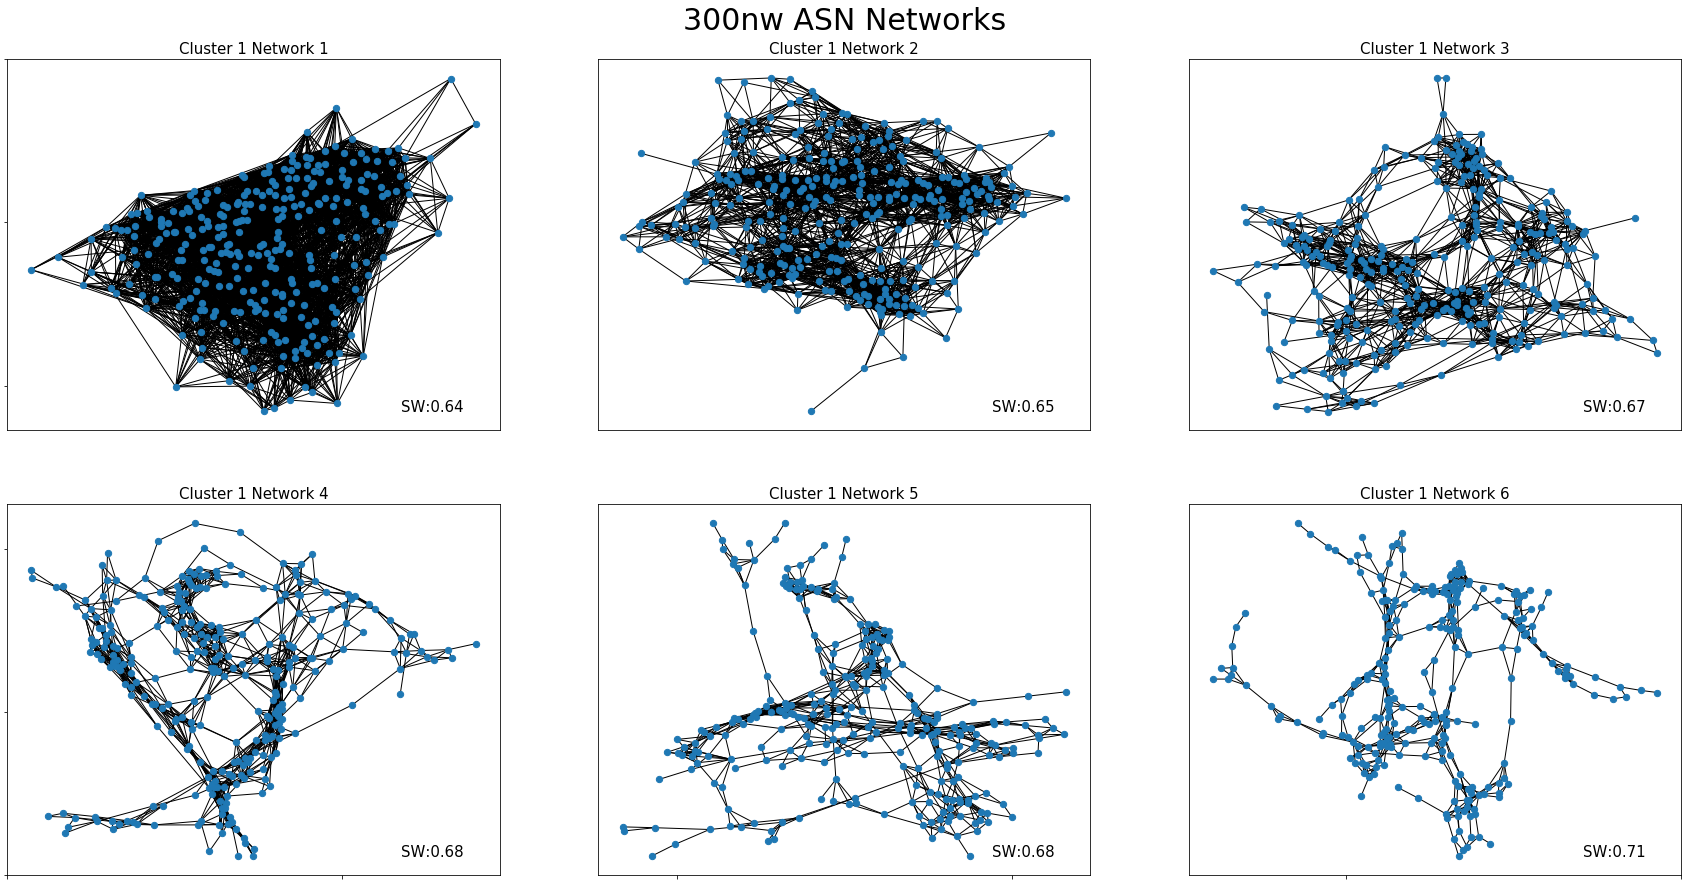

In [27]:
#Plot Networks
fig1=plt.figure(figsize=(30,15))

ax=[None]*len(cluster1)
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('300nw ASN Networks',fontsize=30,pad=30)
# plt.xlabel('PCoeff',fontsize=30,labelpad=15)
# plt.ylabel('MZ',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0
for i in range(len(ax)):
    ax[i]=fig1.add_subplot(len(cluster1)/3, len(cluster1)/2, i+1) #change rows and columns to be factors of ASN300 length
    nx.draw_networkx(ASN300[i]['G'],node_size=40,with_labels=False)
    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
    plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(smallworld[i]),transform=ax[i].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
#     ax[i].set_ylim(-1.5,1.5)
#     ax[i].set_xlim(-1.5,1.5)


#PATH LENGTH + CLUSTERING

In [153]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = [None]*len(cluster1)
pcoeff= [None]*len(cluster1)
mz= [None]*len(cluster1)
clustering = [None]*len(cluster1)
count1=0
count2=0
count3=0
for i in range(len(cluster1)):
    ci[i],q=nct.community_louvain(ASN300[i]['adj_matrix'])
    pcoeff[i]=bct.participation_coef(ASN300[i]['adj_matrix'],ci[i])
    mz[i]=bct.module_degree_zscore(ASN300[i]['adj_matrix'],ci[i])
    clustering[i]=nx.clustering(ASN300[i]['G'])
    ASN300[i]['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(ASN300[i]['G']))
    ASN300[i]['Graph Theory']['Modularity']=ci[i]
    ASN300[i]['Graph Theory']['PCoeff']=pcoeff[i]
    ASN300[i]['Graph Theory']['MZ']=mz[i]
    ASN300[i]['Graph Theory']['Small World']=smallworld[i]
    ASN300[i]['Graph Theory']['CCoeff']=clustering[i]
    ASN300[i]['Graph Theory']['Degree']=nx.degree(ASN300[i]['G'])
    
    if i < len(cluster1):
        cluster1[count1]['Graph Theory']['PL']=ASN300[i]['Graph Theory']['PL']
        cluster1[count1]['Graph Theory']['Modularity']= ASN300[i]['Graph Theory']['Modularity']
        cluster1[count1]['Graph Theory']['PCoeff']=ASN300[i]['Graph Theory']['PCoeff']
        cluster1[count1]['Graph Theory']['MZ']=ASN300[i]['Graph Theory']['MZ']
        cluster1[count1]['Graph Theory']['Small World']=ASN300[i]['Graph Theory']['Small World']
        cluster1[count1]['Graph Theory']['CCoeff']= ASN300[i]['Graph Theory']['CCoeff']
        cluster1[count1]['Graph Theory']['Degree']= ASN300[i]['Graph Theory']['Degree']
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         cluster2[count2]['Graph Theory']['PL']=ASN300[i]['Graph Theory']['PL']
#         cluster2[count2]['Graph Theory']['Modularity']= ASN300[i]['Graph Theory']['Modularity']
#         cluster2[count2]['Graph Theory']['PCoeff']=ASN300[i]['Graph Theory']['PCoeff']
#         cluster2[count2]['Graph Theory']['MZ']=ASN300[i]['Graph Theory']['MZ']
#         cluster2[count2]['Graph Theory']['Small World']=ASN300[i]['Graph Theory']['Small World']
#         cluster2[count2]['Graph Theory']['CCoeff']= ASN300[i]['Graph Theory']['CCoeff']
#         cluster2[count2]['Graph Theory']['Degree']= ASN300[i]['Graph Theory']['Degree']
#         count2=count2+1
#     else:
#         cluster3[count3]['Graph Theory']['PL']=ASN300[i]['Graph Theory']['PL']
#         cluster3[count3]['Graph Theory']['Modularity']= ASN300[i]['Graph Theory']['Modularity']
#         cluster3[count3]['Graph Theory']['PCoeff']=ASN300[i]['Graph Theory']['PCoeff']
#         cluster3[count3]['Graph Theory']['MZ']=ASN300[i]['Graph Theory']['MZ']
#         cluster3[count3]['Graph Theory']['Small World']=ASN300[i]['Graph Theory']['Small World']
#         cluster3[count3]['Graph Theory']['CCoeff']= ASN300[i]['Graph Theory']['CCoeff']
#         cluster3[count3]['Graph Theory']['Degree']= ASN300[i]['Graph Theory']['Degree']
#         count3=count3+1

In [29]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

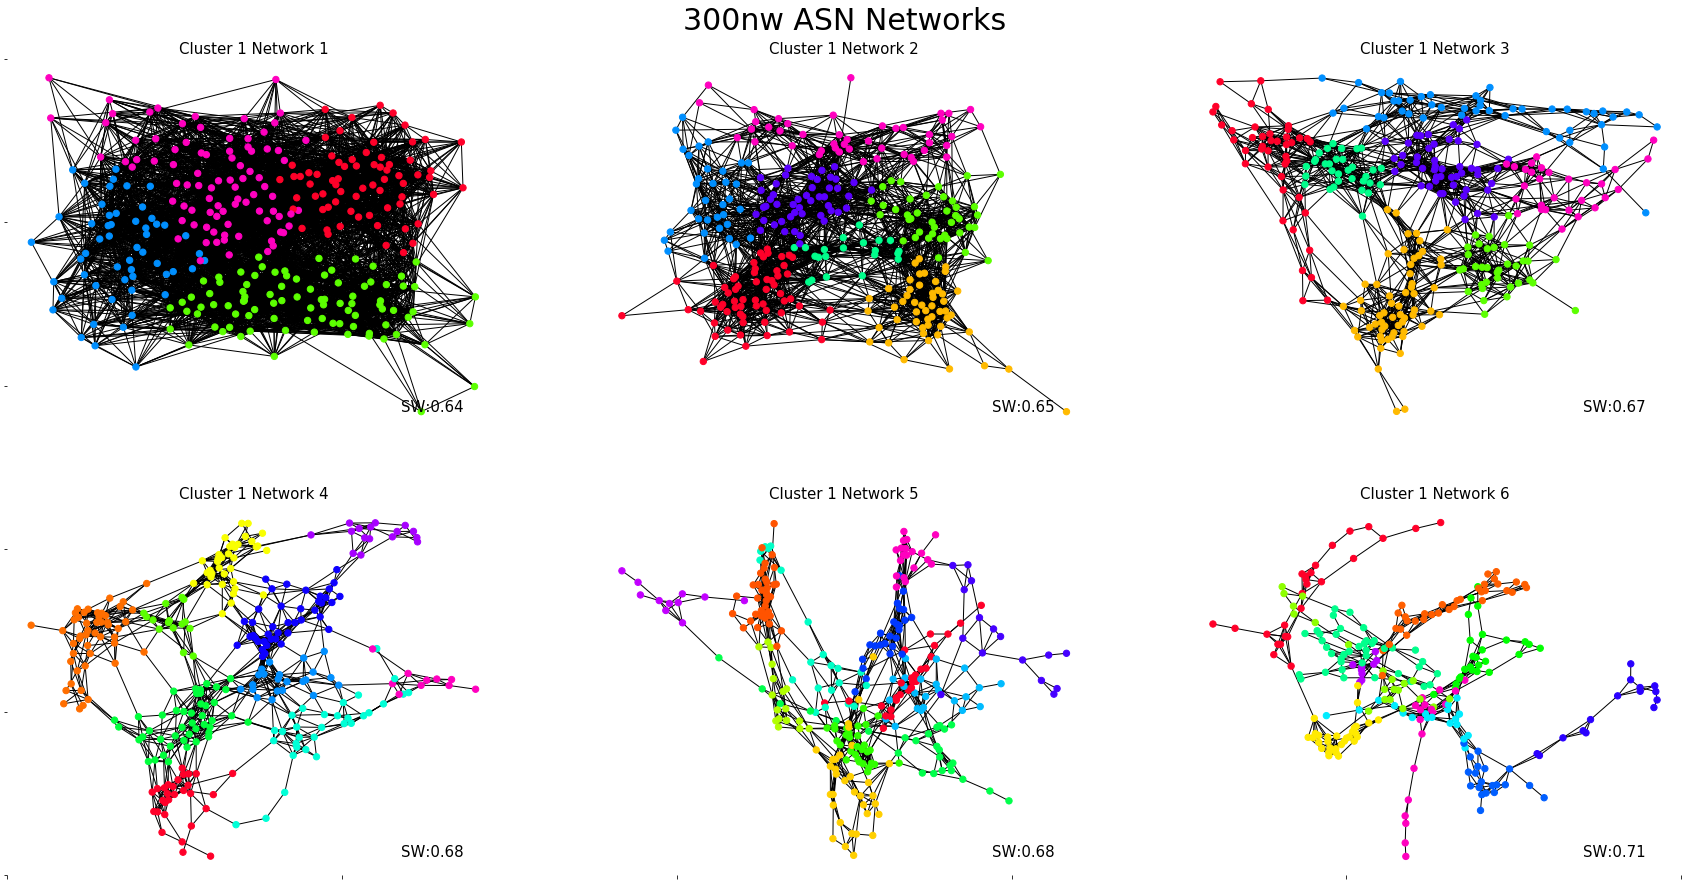

In [30]:
### MODULARITY
from community import community_louvain

fig1=plt.figure(figsize=(30,15))

ax=[None]*len(cluster1)
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('300nw ASN Networks',fontsize=30,pad=30)
# plt.xlabel('PCoeff',fontsize=30,labelpad=15)
# plt.ylabel('MZ',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0
for i in range(len(ax)):
    ax[i]=fig1.add_subplot(len(cluster1)/3, len(cluster1)/2, i+1)
    g=ASN300[i]['G']
    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1   
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)
    nx.draw(g, node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=40);
    plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(smallworld[i]),transform=ax[i].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot

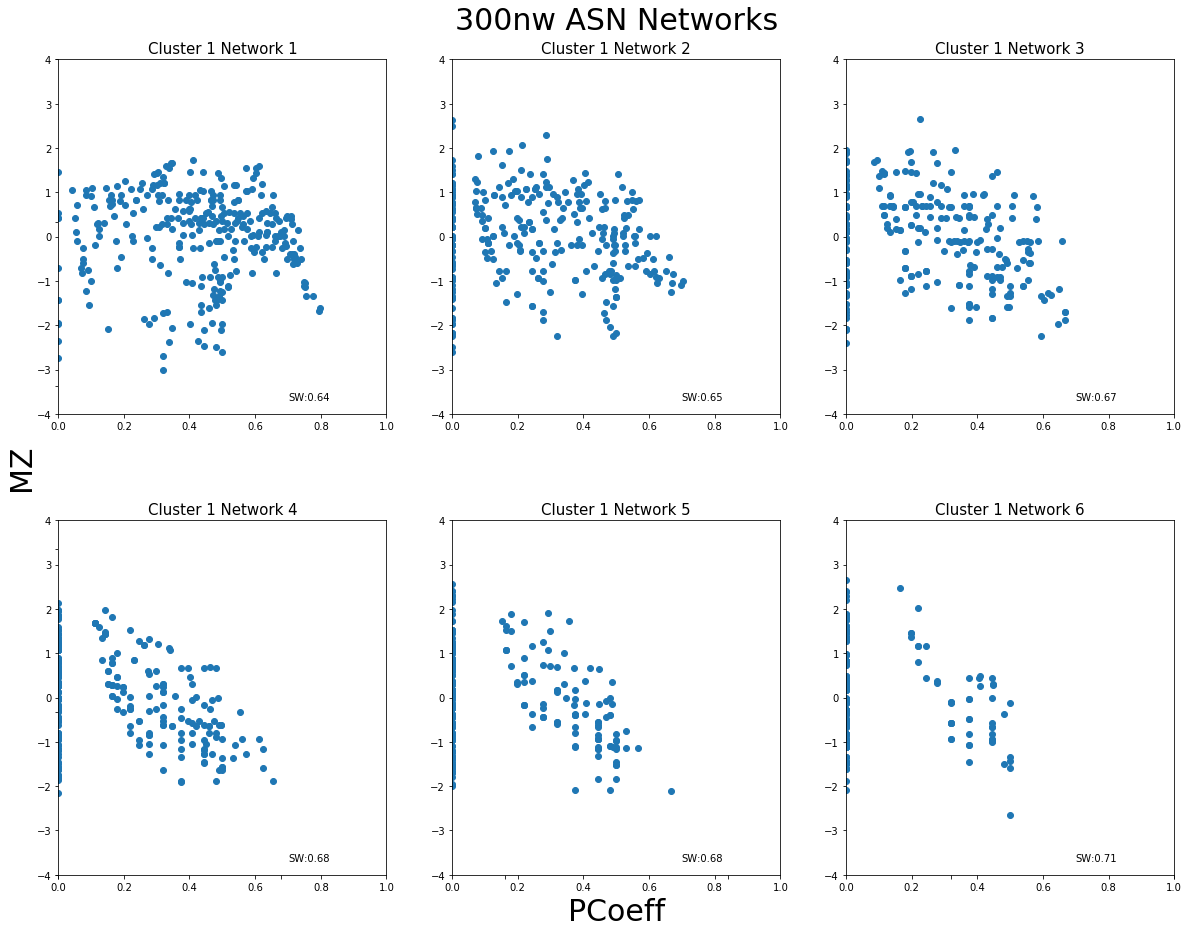

In [32]:
#Plot Participation Coefficient vs MZ
fig1=plt.figure(figsize=(20,15))

ax=[None]*len(cluster1)
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('300nw ASN Networks',fontsize=30,pad=30)
plt.xlabel('PCoeff',fontsize=30,labelpad=15)
plt.ylabel('MZ',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0
for i in range(len(ax)):
    ax[i]=fig1.add_subplot(len(cluster1)/3, len(cluster1)/2, i+1)
    fig1.subplots_adjust(hspace=.3)
    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
    plt.scatter(pcoeff[i],mz[i])
    plt.text(0.7,-3.7,'SW:'+"{0:.2f}".format(smallworld[i]))
    ax[i].set_ylim(-4,4)
    ax[i].set_xlim(0,1)

# DC Functional Exploration

In [36]:
onAmp=[]
shortestPath=[None]*len(cluster1)
for i in range(len(cluster1)):
    temp=getFarthestPairing(ASN300[i]['adj_matrix'])
    shortestPath[i]=nx.shortest_path_length(ASN300[i]['G'],temp[0],temp[1])
    onAmp.append(shortestPath[i]/5)

In [46]:
## RUN DC TASK:
dt = 1e-2
f=0.5
Time=5
results_DC=[None]*len(cluster1)
stimulus=[[],[]]
biasType='DC'
for i in range(len(onAmp)):
    stimulus[0].append((stimulus__(biasType=biasType,onAmp=onAmp[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    
for i in range(len(cluster1)): #for each network
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
    results_DC[i]=runSim(connectivity__(wires_dict=ASN300[i]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = dt, onAmp = onAmp[i], biasType=biasType,f=f,junctionMode='tunneling')
    results_DC[i].frequency=f
    results_DC[i].dt=dt

2020-04-08 10:21:11,935:INFO:First current path [132, 153, 98, 179, 203, 140] formed at time = 0.55 s.


2020-04-08 10:21:12,825:INFO:First current path [58, 188, 99, 70, 214, 234, 210, 272, 132] formed at time = 0.57 s.


2020-04-08 10:21:13,557:INFO:First current path [97, 281, 231, 205, 42, 34, 99, 79, 68, 8, 201, 181] formed at time = 0.58 s.


2020-04-08 10:21:14,218:INFO:First current path [56, 112, 83, 239, 236, 75, 118, 233, 144, 194, 97, 61, 131, 251, 278, 96] formed at time = 0.58 s.


2020-04-08 10:21:14,829:INFO:First current path [55, 108, 28, 201, 215, 193, 276, 66, 158, 262, 75, 9, 206, 26, 189, 178, 264, 165, 144, 27, 149, 175, 146, 137] formed at time = 0.6 s.


2020-04-08 10:21:15,334:INFO:First current path [178, 129, 79, 21, 134, 135, 219, 238, 150, 73, 120, 29, 172, 239, 189, 24, 176, 165, 52, 152, 131, 25, 136, 162, 133, 124] formed at time = 0.56 s.


In [419]:
shortestPath

[5, 8, 11, 15, 23, 25]

In [33]:
#Subgraph AdjMat
def getOnGraph(network, this_TimeStamp = 0):
    edgeList = network.connectivity.edge_list
    adjMat = np.zeros((network.numOfWires, network.numOfWires))
    adjMat[edgeList[:,0], edgeList[:,1]] = network.junctionSwitch[this_TimeStamp,:]
    adjMat[edgeList[:,1], edgeList[:,0]] = network.junctionSwitch[this_TimeStamp,:]
    onGraph = nx.from_numpy_array(adjMat)
    
    return onGraph

In [89]:
#Communicability + Current Matrices
def commCurr(sim):
    startTime=0
    timeSteps=50
    time_index=[startTime,len(sim.junctionResistance),timeSteps]
    currMat=[None]*len(range(startTime,len(sim.junctionResistance),timeSteps))
    commu_Edges=[None]*len(range(startTime,len(sim.junctionResistance),timeSteps))
    commu_Mat=[None]*len(range(startTime,len(sim.junctionResistance),timeSteps))
    new_currGraph=[None]*len(range(startTime,len(sim.junctionResistance),timeSteps))
    count = 0
    for i in tqdm(range(startTime,len(sim.junctionResistance),timeSteps)): #for each timestep
        currMat[count] = np.zeros((sim.numOfWires,sim.numOfWires))
        edgeList = sim.connectivity.edge_list
        currMat[count][edgeList[:,0], edgeList[:,1]] = sim.junctionVoltage[i,:]/sim.junctionResistance[i,:] #-1,:
        currMat[count] = currMat[count] + currMat[count].T
        currGraph = nx.from_numpy_array(currMat[count])
        subGraph = getOnGraph(sim, this_TimeStamp=i)

        components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

        max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
        currGraph = nx.subgraph(currGraph, components[max_ind])
        new_currGraph[count] = currGraph
        currMat[count] = np.array(nx.adjacency_matrix(new_currGraph[count]).todense())

        commu = nx.communicability(new_currGraph[count])
        commu_Edges[count]=commu
        subSize = len(currGraph)
        nodes_BIGKEV=list(currGraph.nodes)

        commu_Mat[count] = np.array([commu[k][j] for k in nodes_BIGKEV for j in nodes_BIGKEV]).reshape(subSize,subSize)
        count = count+1
        
    return commu_Edges,commu_Mat, currMat, new_currGraph, time_index

In [91]:
#Current and Communicability Matrices:
commuMatASN=[None]*len(results_DC)
currMatASN=[None]*len(results_DC)
currGraphASN=[None]*len(results_DC)
commu_edgesASN=[None]*len(results_DC)
time_index=[None]*len(results_DC)
count1=0
count2=0
count3=0
for i in tqdm(range(len(results_DC))):
    commu_edgesASN[i],commuMatASN[i],currMatASN[i],currGraphASN[i],time_index[i]=commCurr(results_DC[i]) #calculate communicability every 500 time steps for each network
    if i < len(cluster1):
        cluster1[count1]['Graph Theory']['COMM Mat']=commuMatASN[i]
        cluster1[count1]['Graph Theory']['COMM Edges']=commu_edgesASN[i]
        cluster1[count1]['Graph Theory']['Current Matrix']=currMatASN[i]
        cluster1[count1]['Graph Theory']['Subgraph']=currGraphASN[i]
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         cluster2[count2]['Graph Theory']['COMM Mat']=commuMatASN_LT[i]
#         cluster2[count2]['Graph Theory']['COMM Edges']=commu_edgesASN_LT[i]
#         cluster2[count2]['Graph Theory']['Current Matrix']=currMatASN_LT[i]
#         cluster2[count2]['Graph Theory']['Subgraph']=currGraphASN_LT[i]
#         count2=count2+1
#     else:
#         cluster3[count3]['Graph Theory']['COMM Mat']=commuMatASN_LT[i]
#         cluster3[count3]['Graph Theory']['COMM Edges']=commu_edgesASN_LT[i]
#         cluster3[count3]['Graph Theory']['Current Matrix']=currMatASN_LT[i]
#         cluster3[count3]['Graph Theory']['Subgraph']=currGraphASN_LT[i]
#         count3=count3+1

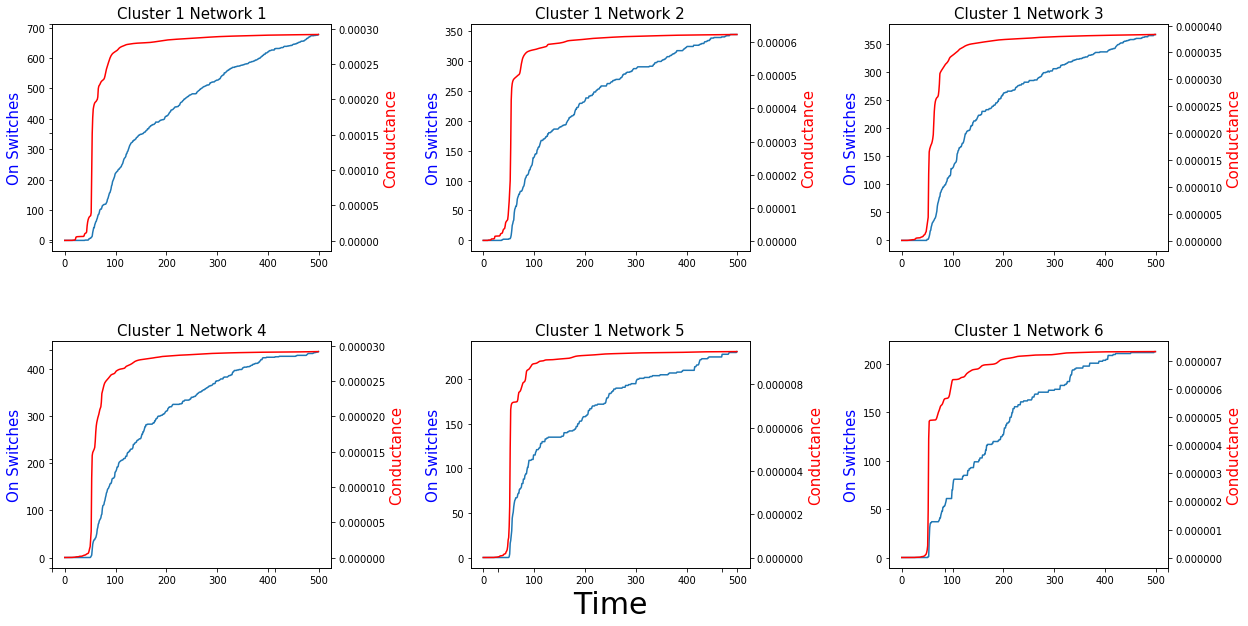

In [92]:
#network junctions switches:
fig1=plt.figure(figsize=(20,10))
ax=[None]*len(cluster1)#numNetworks
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xlabel('Time',fontsize=30,labelpad=15)
# plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0

for i in range(len(cluster1)):
    ax[i]=fig1.add_subplot(len(cluster1)/3, len(cluster1)/2, i+1)
    fig1.subplots_adjust(hspace=.4)
    fig1.subplots_adjust(wspace=.5)

    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
    plt.plot(np.sum(results_DC[i].junctionSwitch,1))
    ax2 = ax[i].twinx()
    ax2.plot(results_DC[i].conductance,color='r')
    ax[i].set_ylabel('On Switches', color='b',fontsize=15)
    ax2.set_ylabel('Conductance', color='r',fontsize=15)
    #votlage as title 

## Plot Results

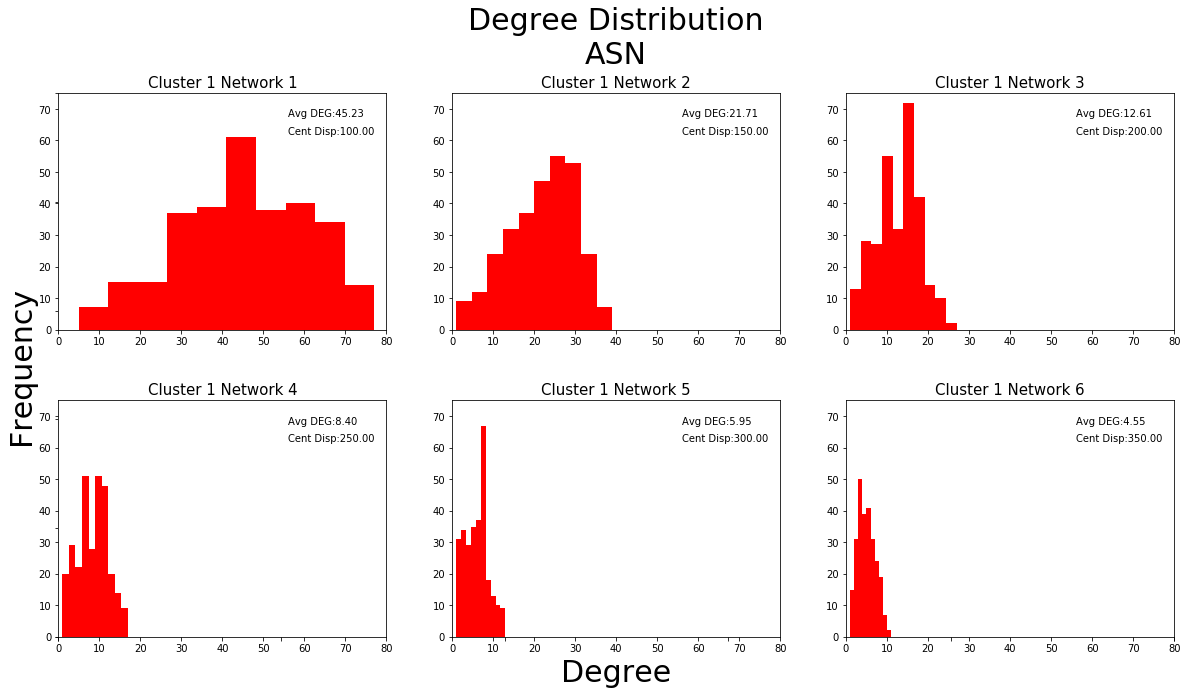

In [411]:
fig1=plt.figure(figsize=(20,10))

ax=[None]*(len(cluster1))
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('Degree Distribution\nASN',fontsize=30,pad=30)
plt.ylabel('Frequency',fontsize=30,labelpad=15)
plt.xlabel('Degree',fontsize=30,labelpad=15)

# plt.ylabel('MZ',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0
meanDeg=[]
for i in range(len(ax)):
    ax[i]=fig1.add_subplot((len(cluster1))/3, (len(cluster1))/2, i+1)
#     if i == len(ax)-1:

#     else:
    fig1.subplots_adjust(hspace=.4)
    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1

#     dictionary2=dict(Elegans['Graph Theory']['Degree'])
#     plt.hist(dictionary2.values(), color='b',label='Elegans')
    dictionary=dict(ASN300[i]['Graph Theory']['Degree'])
    fig1.subplots_adjust(hspace=.3)
#     ax[i].set_title('ASN Network ' + str(i+1),fontsize=15)
    plt.hist(dictionary.values(), color='r',label='ASN')
    meanDeg.append(np.mean(list(dictionary.values())))
    plt.ylim(0,75)
    plt.xlim(0,80)
    
    plt.text(0.7,0.9,'Avg DEG:'+"{0:.2f}".format(meanDeg[i]),transform=ax[i].transAxes,fontsize=10) #this plots Smallworldness as text in a relative position on each subplot
    plt.text(0.7,0.825,'Cent Disp:'+"{0:.2f}".format(cluster1[i]['centroid_dispersion']),transform=ax[i].transAxes,fontsize=10) #this plots Smallworldness as text in a relative position on each subplot

    # plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\'Degree ASN vs C Elegans.jpg')



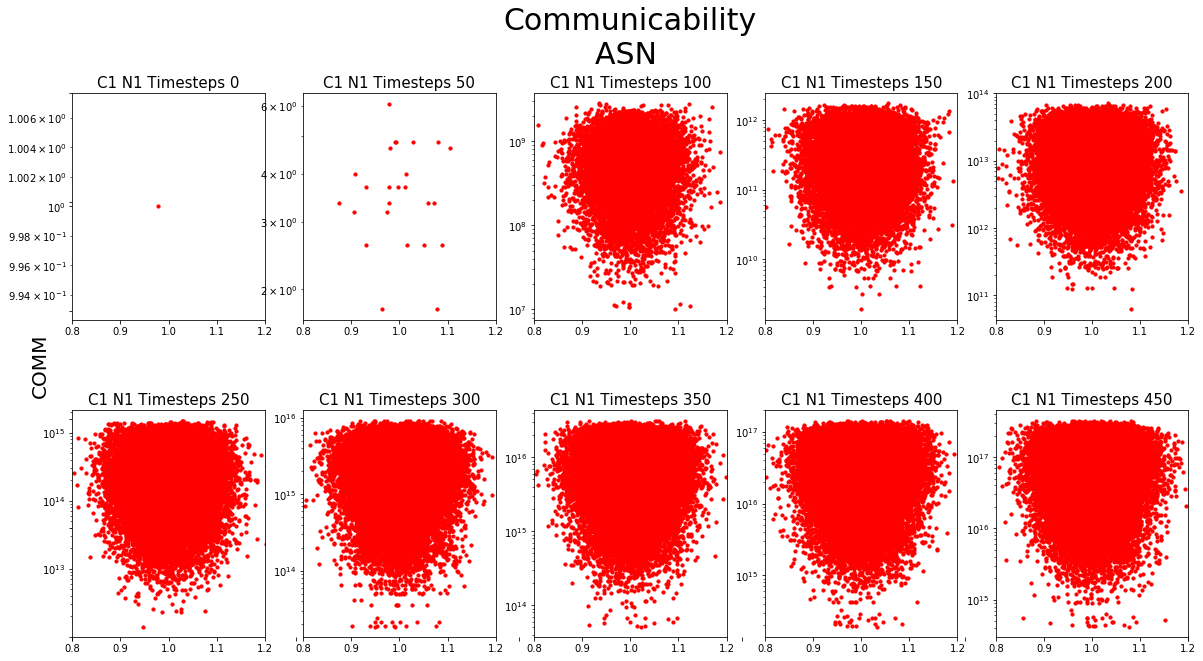

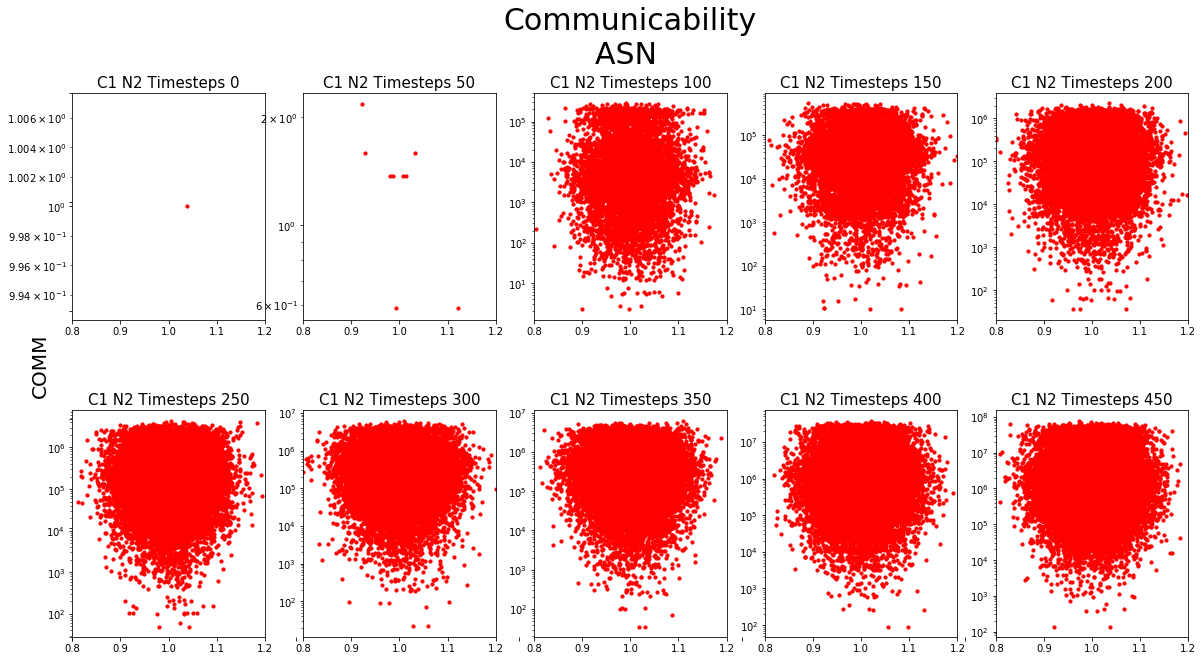

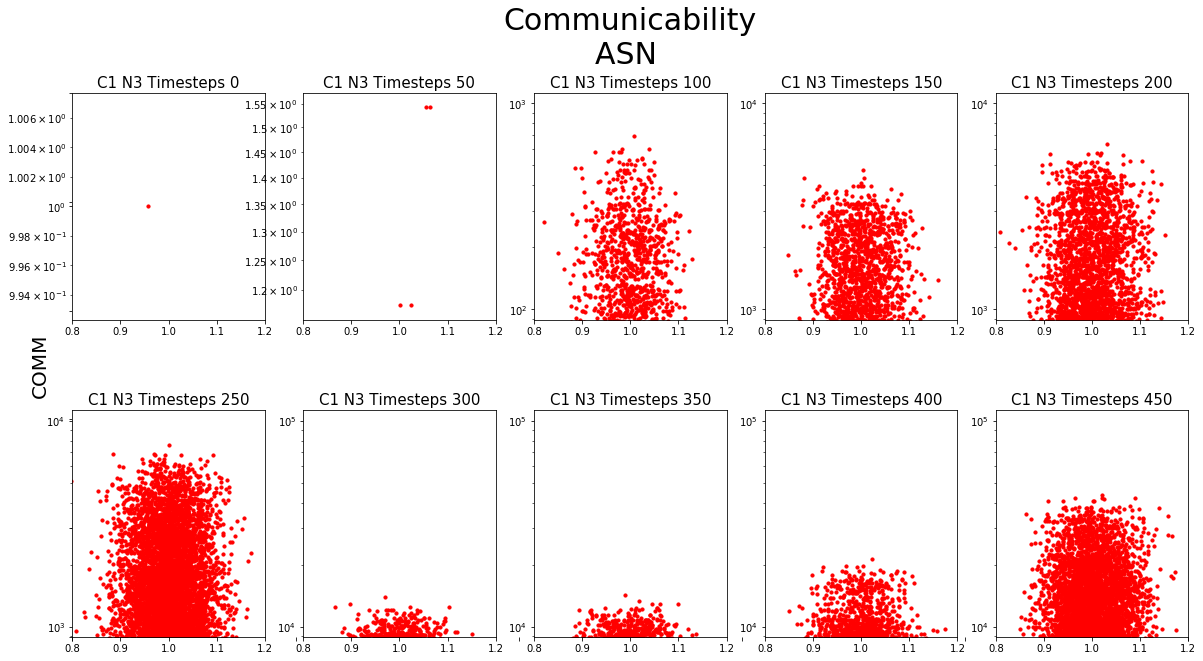

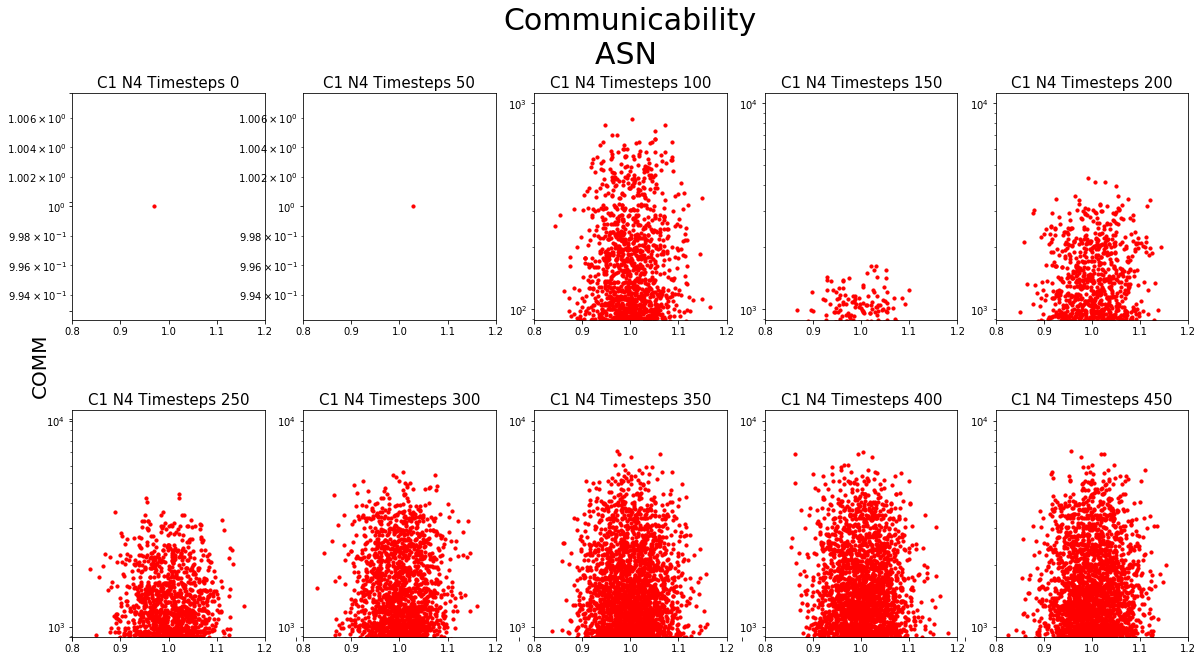

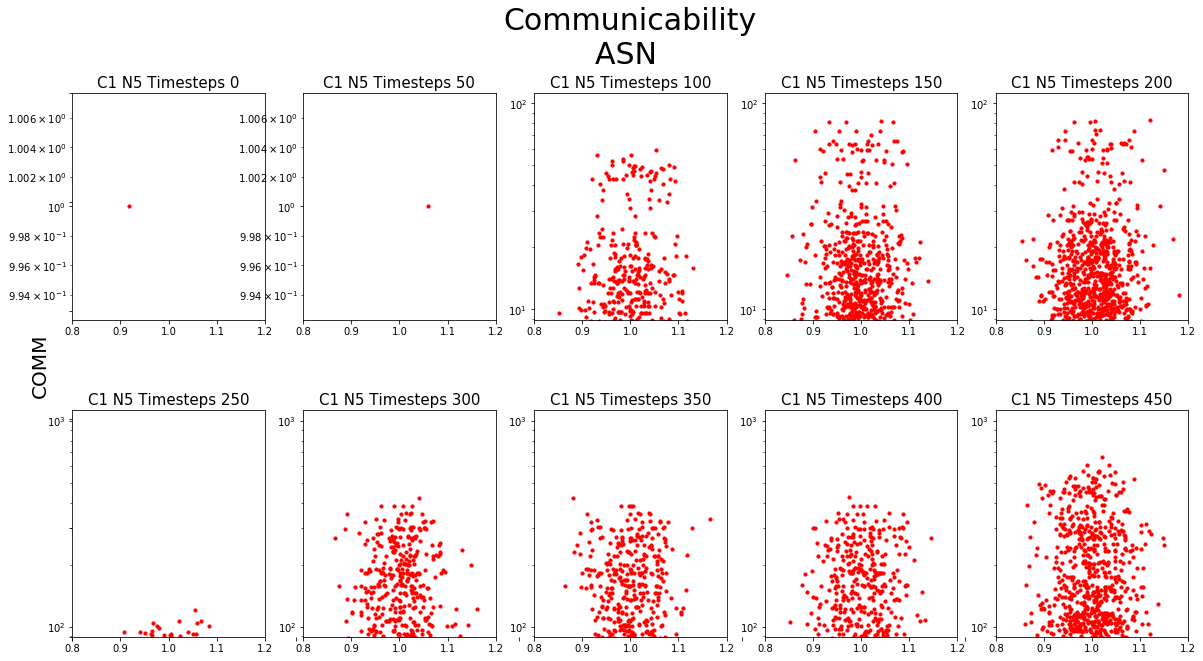

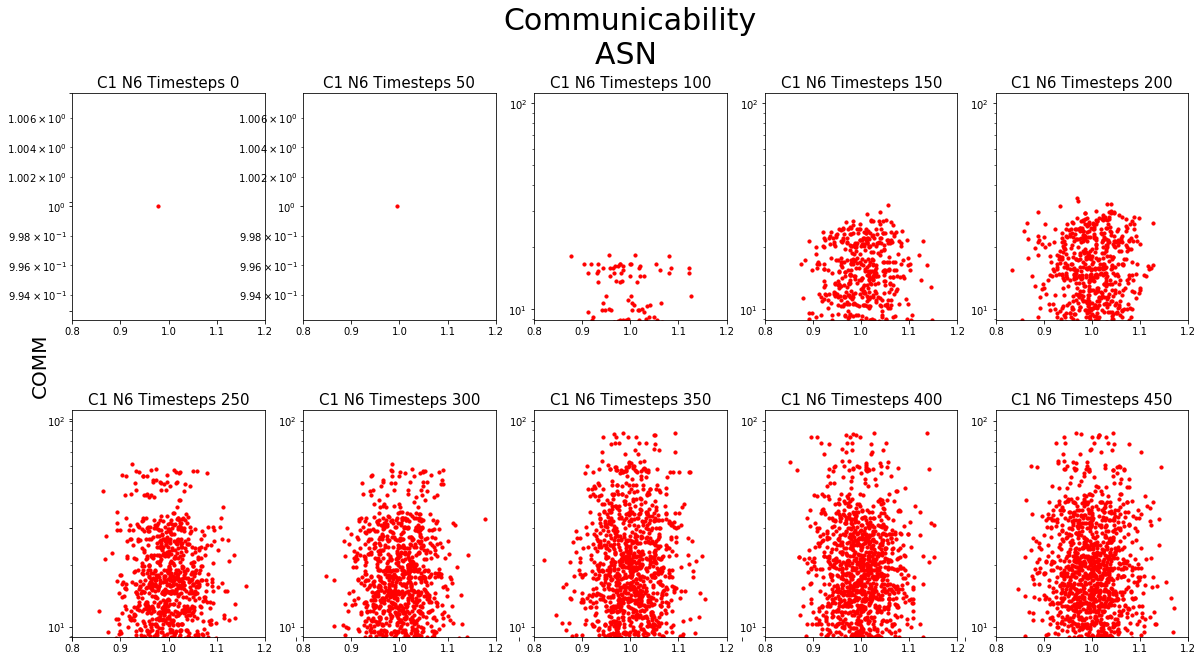

In [396]:
### COMMUNICABILITY:
times=range(time_index[0][0],time_index[0][1],time_index[0][2])
count1=0
count2=0
count3=0
for i in range(len(cluster1)): #for each network
    fig1=plt.figure(figsize=(20,10))
    ax=[None]*(len(commuMatASN[i]))
    axBig = fig1.add_subplot(111)
    axBig.set_yticklabels([])
    axBig.set_xticklabels([])
    axBig.set_frame_on(False)
    plt.title('Communicability\nASN ',fontsize=30,pad=30)
    for j in range(len(commuMatASN[i])): #for each timepoint
        times=range(0,len(commuMatASN[i]))
        ax[j]=fig1.add_subplot((len(commuMatASN[i]))/5, (len(commuMatASN[i]))/2, j+1)
        fig1.subplots_adjust(hspace=.4)
    #     if i < len(cluster1):
        ax[j].set_title('C1 N' + str(count1+1) +' Timesteps ' +str(times[j]*50),fontsize=15)
       
    #     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
    #         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
    #         count2=count2+1
    #     else:
    #         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
    #         count3=count3+1
    #     if i == len(ax)-1:


    #     else:
        #Elegans
        axBig.set_ylabel('COMM' ,fontsize=20,labelpad=15)
    #     randSizeElegans = commuMatElegans_LT[j][currMatElegans_LT[j]!=0].size 
    #     xrandElegans = np.random.normal(1, 0.05, randSizeElegans)
    #     plt.scatter(xrandElegans, commuMatElegans_LT[j][currMatElegans_LT[j]!=0], color = 'b',s=10,label='Elegans')    
    #     ax[i].set_title('C Elegans ',fontsize=15)

    #     plt.text(0.81,30e6, ElegansText,fontsize=8)
#         plt.yscale("log")
#         plt.xlim(0.8,1.2)
    #     plt.ylim(0,10e8)    
        #ASN
    #     ax[i].set_title('ASN Network ' + str(i+1),fontsize=15)
        randSizeASN = commuMatASN[i][j].size 
        xrandASN = np.random.normal(1, 0.05, randSizeASN)
        plt.scatter(xrandASN, commuMatASN[i][j], color = 'r',s=10,label='ASN')    
        plt.yscale("log")
        plt.xlim(0.8,1.2)
    #     plt.ylim(0,10e8)     
    #     plt.yticks(np.arange(0,10e10,step=10e2))
    
    count1=count1+1
    #     plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\'COMM ASN vs C Elegans_' + str(times[j]*1000) +' Timesteps_Cluster 1.jpg')
    #     plt.text(0.81,10e7, ASNText,fontsize=8)

    #     plt.text(0.7,-3.7,'SW:'+"{0:.2f}".format(smallworld[i]))
    #     ax[i].set_ylim(-4,4)
    #     ax[i].set_xlim(0,1)


    # for j in range(len(WS_Random)):
    #     randSizeRandom = commuMatRandom[j][currMatRandom[j]!=0].size    
    #     xrandRandom = np.random.normal(2, 0.05, randSizeRandom)
    #     plt.scatter(xrandRandom, commuMatRandom[j][currMatRandom[j]!=0], color = '#FF1212',s=1)

    # for j in range(len(ASN300)):
    #     randSizeASN = commuMatASN[j][currMatASN[j]!=0].size    
    #     xrandASN = np.random.normal(3, 0.05, randSizeASN)
    #     plt.scatter(xrandASN, commuMatASN[j][currMatASN[j]!=0], color = '#FF5233',s=1)


    # for i in range(len(Elegans)):
    #     randSizeElegans = commuMatElegans[i][currMatElegans[i]!=0].size    
    #     xrandElegans = np.random.normal(4, 0.05, randSizeElegans)
    #     plt.scatter(xrandElegans, commuMatElegans[i][currMatElegans[i]!=0], color = '#FFBE33',s=10)

    # plt.yscale("log")
    # plt.ylim(1)
    # plt.xticks([1,2,3,4],[r"Grid Networks","Random Networks","ASN Networks", r"$\it{C. Elegans}$"],rotation='45')
    # plt.ylabel("log(Communicability)")


## Linear Transform Task:

In [127]:
#set up accuracy dictionary for ASN
count1=0
count2=0
count3=0
for i in range(len(cluster1)):
    ASN300[i].update({'Accuracy':{'Linear Transformation':[],'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[]},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
#set up accuracy dictionary for ASN Clusters
    if i < len(cluster1):
        cluster1[count1].update({'Accuracy':{'Linear Transformation':[],'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[]},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
        count1=count1+1

In [128]:
#Instantiate Variables       
stimulus=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
#figure out voltage for each network:


#Choose Electrode Pattern
for i in range(len(onAmp)):
    stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    
#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results_ASN=[None]*len(cluster1)
ResultSqu=[None]*len(cluster1)

# Voltage=[None]*len(ASN300)
# Switches=[None]*len(ASN300)



nodesList=[None]*len(cluster1)
#Run Simulations
count1=0
count2=0
count3=0
for i in range(len(cluster1)): #for each network
    nwSqu = []
    print('Network ' + str(i+1))
    #Run Simulations
#     results=[]
    # Connectivity=connectivity__('700nw_14533junctions.mat')
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#     set_trace()
    results_ASN[i]=runSim(connectivity__(wires_dict=ASN300[i]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp[i], biasType='AC',f=f,junctionMode='tunneling')
    #wires_dict=newNetworkTest[chosenNetwork])
    results_ASN[i].frequency=f
    results_ASN[i].dt=0.001
    period=1/f

    TimeVector=results_ASN[i].TimeVector
    voltage=results_ASN[i].wireVoltage
    conductance=results_ASN[i].conductance
    switches=results_ASN[i].junctionSwitch

    stepNodes=len(ASN300[i])-1 #first use all nodes
    sizes2=len(ASN300[i])
    nwOutputs = [None]* int(sizes2/stepNodes)
            
    outputNodes2=[]

    for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
        np.random.seed(69)

        outputNodes2.append(voltage[:,np.random.choice(len(voltage[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes

        nwOutputs=outputNodes2 #Length of nwOutputs is k (list)

    target1=[None]*len(nwOutputs)
    target2=[None]*len(nwOutputs)
    target3=[None]*len(nwOutputs)
    target4=[None]*len(nwOutputs)
    target5=[None]*len(nwOutputs)

    for j in range(len(nwOutputs)):
        target1[j] = (onAmp[i] * (-np.sign(TimeVector % period - period/2)))
        target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
        target3[j] = (onAmp[i]/period * (TimeVector % period))
        target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))


#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]

#        ResultTri=[]
#        ResultSaw=[]
    accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
    output=[]
    mSqu=[]
#        mTri=[]
#        mSaw=[]
#        mDbl=[]
    
    if len(ASN300[i]['G']) >= 250:
        nodesList[i]=[50,100,150,200,250,len(ASN300[i]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(ASN300[i]['G']) >= 200 and len(ASN300[i]['G']) < 250:
        nodesList[i]=[50,100,150,200,len(ASN300[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[i]['G']) >= 150 and len(ASN300[i]['G']) < 200:
        nodesList[i]=[50,100,150,len(ASN300[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[i]['G']) >= 100 and len(ASN300[i]['G']) < 150:
        nodesList[i]=[50,100,len(ASN300[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
                     
#     set_trace()

    for j in nodesList[i]: #range(50, len(ws300[i][0])+1,50): #loop through sets of nodes 
        print('Running Regression: ' + str(j) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_ASN[i],'Square',j, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    # OLD WAY: NOKEVregression(target1[j],nwOutputs[j].T)[0]
    # OLD WAY: outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
    # temp=np.dot(outputx,ResultSqu)
    # MSE=np.mean((target1[j]-temp)**2)
    # rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
        nwSqu.append(ResultSqu['accuracy'])       
    ASN300[i]['Accuracy']['Linear Transformation']=nwSqu
    if i < len(cluster1):
        cluster1[count1]['Accuracy']['Linear Transformation']=nwSqu
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         cluster2[count2]['Accuracy']['Linear Transformation']=nwSqu
#         count2=count2+1
#     else:
#         cluster3[count3]['Accuracy']['Linear Transformation']=nwSqu
#         count3=count3+1

Network 1


2020-04-08 11:00:41,180:INFO:First current path [132, 153, 98, 179, 203, 140] formed at time = 0.763 s.


Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Network 2


2020-04-08 11:01:00,805:INFO:First current path [58, 188, 99, 70, 214, 234, 210, 272, 132] formed at time = 0.783 s.


Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Network 3


2020-04-08 11:01:20,562:INFO:First current path [97, 281, 231, 205, 42, 34, 99, 79, 68, 8, 201, 181] formed at time = 0.83 s.



Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 295 nodes
Network 4


2020-04-08 11:01:39,164:INFO:First current path [56, 112, 29, 92, 13, 175, 217, 259, 33, 215, 253, 252, 257, 265, 278, 96] formed at time = 0.872 s.


Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 292 nodes
Network 5


2020-04-08 11:01:57,319:INFO:First current path [55, 108, 28, 201, 215, 193, 276, 66, 158, 262, 75, 183, 227, 114, 138, 254, 58, 165, 144, 27, 149, 175, 146, 137] formed at time = 0.827 s.



Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 283 nodes
Network 6


2020-04-08 11:02:14,112:INFO:First current path [178, 129, 79, 21, 134, 135, 219, 238, 150, 73, 120, 29, 172, 239, 189, 24, 176, 165, 52, 152, 131, 25, 136, 162, 133, 124] formed at time = 0.808 s.



Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 259 nodes


In [130]:
#Current and Communicability Matrices:
commuMatASN_LT=[None]*len(results_ASN)
currMatASN_LT=[None]*len(results_ASN)
currGraphASN_LT=[None]*len(results_ASN)
commu_edgesASN_LT=[None]*len(results_ASN)
time_index=[None]*len(results_ASN)
count1=0
count2=0
count3=0
for i in tqdm(range(len(results_ASN))):
    commu_edgesASN_LT[i],commuMatASN_LT[i],currMatASN_LT[i],currGraphASN_LT[i],time_index[i]=commCurr(results_ASN[i]) #calculate communicability every 500 time steps for each network
    if i < len(cluster1):
        cluster1[count1]['Graph Theory']['COMM Mat']=commuMatASN_LT[i]
        cluster1[count1]['Graph Theory']['COMM Edges']=commu_edgesASN_LT[i]
        cluster1[count1]['Graph Theory']['Current Matrix']=currMatASN_LT[i]
        cluster1[count1]['Graph Theory']['Subgraph']=currGraphASN_LT[i]
        count1=count1+1
    elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
        cluster2[count2]['Graph Theory']['COMM Mat']=commuMatASN_LT[i]
        cluster2[count2]['Graph Theory']['COMM Edges']=commu_edgesASN_LT[i]
        cluster2[count2]['Graph Theory']['Current Matrix']=currMatASN_LT[i]
        cluster2[count2]['Graph Theory']['Subgraph']=currGraphASN_LT[i]
        count2=count2+1
    else:
        cluster3[count3]['Graph Theory']['COMM Mat']=commuMatASN_LT[i]
        cluster3[count3]['Graph Theory']['COMM Edges']=commu_edgesASN_LT[i]
        cluster3[count3]['Graph Theory']['Current Matrix']=currMatASN_LT[i]
        cluster3[count3]['Graph Theory']['Subgraph']=currGraphASN_LT[i]
        count3=count3+1

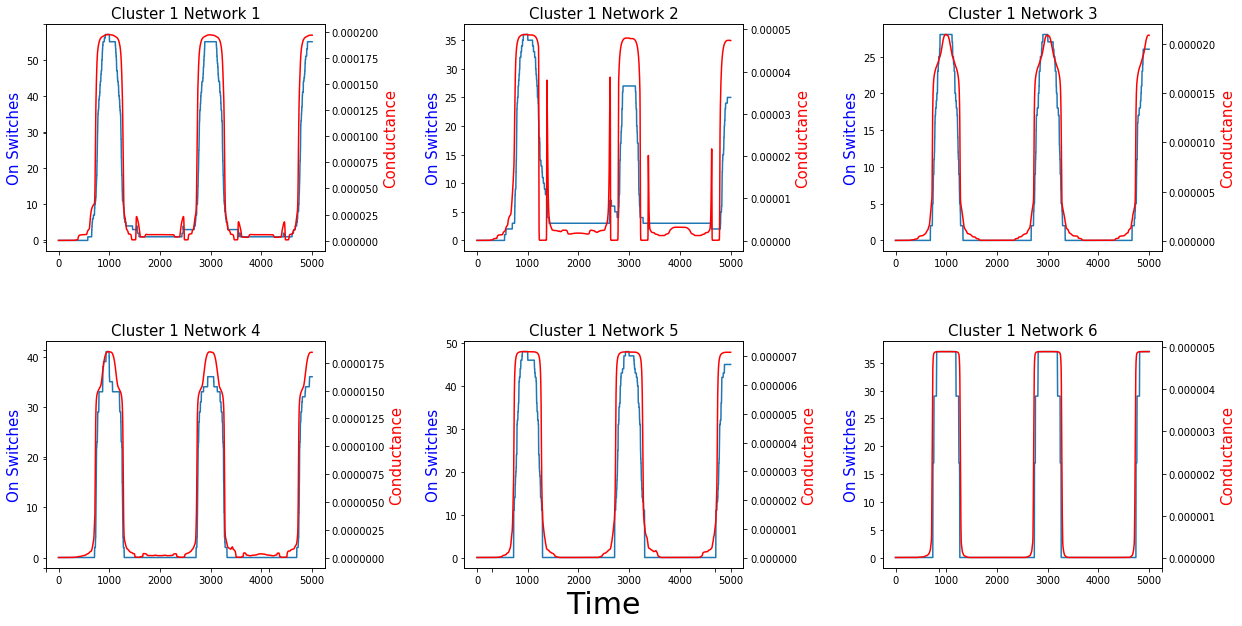

In [132]:
#network junctions switches:
fig1=plt.figure(figsize=(20,10))
ax=[None]*len(cluster1)#numNetworks
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xlabel('Time',fontsize=30,labelpad=15)
# plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
count1=0
count2=0
count3=0

for i in range(len(cluster1)):
    ax[i]=fig1.add_subplot(len(cluster1)/3, len(cluster1)/2, i+1)
    fig1.subplots_adjust(hspace=.4)
    fig1.subplots_adjust(wspace=.5)

    if i < len(cluster1):
        ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
        count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
    plt.plot(np.sum(results_ASN[i].junctionSwitch,1))
    ax2 = ax[i].twinx()
    ax2.plot(results_ASN[i].conductance,color='r')
    ax[i].set_ylabel('On Switches', color='b',fontsize=15)
    ax2.set_ylabel('Conductance', color='r',fontsize=15)
    #votlage as title 

In [413]:
ASNaccuracy=[[None]*len(ASN300) for i in range(len(nodesList[0]))]
cluster1accuracy=[[None]*len(cluster1) for i in range(len(nodesList[0]))]
# cluster2accuracy=[[None]*len(cluster2) for i in range(len(nodesList[0]))]
# cluster3accuracy=[[None]*len(cluster3) for i in range(len(nodesList[0]))]

for i in range(len(cluster1)):
    temp=[]
    for j in range(len(ASN300[i]['Accuracy']['Linear Transformation'])):
        temp=ASN300[i]['Accuracy']['Linear Transformation'][j]
        if j == 0:
            ASNaccuracy[0][i]= temp
        elif j == 1:
            ASNaccuracy[1][i]= temp
        elif j == 2:
            ASNaccuracy[2][i]= temp
        elif j == 3:
            ASNaccuracy[3][i]= temp
        elif j == 4:
            ASNaccuracy[4][i]= temp
        elif j == 5:
            ASNaccuracy[5][i]= temp

for i in range(len(ASNaccuracy)):    
    count1=0
    count2=0
    count3=0
    for j in range(len(ASNaccuracy[i])):
        if j < len(cluster1):
            cluster1accuracy[i][count1]=ASNaccuracy[i][j]
            count1=count1+1
#         elif j >= len(cluster1) and j < (len(cluster1) + len(cluster2)):
#             cluster2accuracy[i][count2]=ASNaccuracy[i][j]
#             count2=count2+1
#         else:
#             cluster3accuracy[i][count3]=ASNaccuracy[i][j]
#             count3=count3+1

Text(0.5, 0, 'Network')

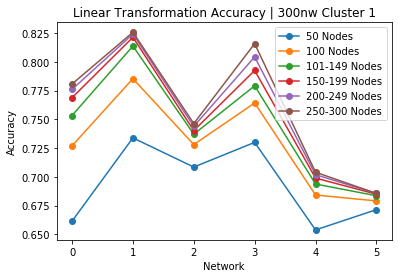

In [412]:
#300nw ASN

labels=['50 Nodes', '100 Nodes', '101-149 Nodes', '150-199 Nodes', '200-249 Nodes', '250-300 Nodes']

# fig1=plt.figure(figsize=(15,15))
ax=[None]*3
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_xticks([])
axBig.set_yticks([])
fig1.subplots_adjust(hspace=.4)

# ax[0]=fig1.add_subplot(3, 2, 1)
for i in range(len(cluster1accuracy)):
    plt.title('Linear Transformation Accuracy | 300nw Cluster 1')
    plt.plot(cluster1accuracy[i],'-o',label=labels[i])
# plt.plot(WS_Rand_Accuracy,label='WS Random')
# plt.plot(WS_Grid_Accuracy,label='WS Grid')
# plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Network')


# ax[1]=fig1.add_subplot(3, 2, 2)
# for i in range(len(cluster2accuracy)):
#     plt.title('Linear Transformation Accuracy | 300nw Cluster 2')
#     plt.plot(cluster2accuracy[i],'-o',label=labels[i])
# # plt.plot(WS_Rand_Accuracy,label='WS Random')
# # plt.plot(WS_Grid_Accuracy,label='WS Grid')
# # plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
# plt.legend()
# plt.ylabel('Accuracy')


# ax[1]=fig1.add_subplot(3, 2, 3)
# for i in range(len(cluster3accuracy)):
#     plt.title('Linear Transformation Accuracy | 300nw Cluster 3')
#     plt.plot(cluster3accuracy[i],'-o',label=labels[i])
# # plt.plot(WS_Rand_Accuracy,label='WS Random')
# # plt.plot(WS_Grid_Accuracy,label='WS Grid')
# # plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
# plt.legend()
# plt.ylabel('Accuracy')

# #Elegans 
# ax[5]=fig1.add_subplot(3, 2, 6)

# for i in range(len(Elegans_Accuracy)):
#     plt.title('Linear Transformation Accuracy | C. Elegans')
#     plt.plot(Elegans_Accuracy[i],'-o',label=labels[i])

# plt.legend()
# plt.ylabel('Accuracy')
# plt.xlabel('Network')


In [414]:
cluster1sw=[]
# cluster2sw=[]
# cluster3sw=[]
for i in range(len(cluster1)):
    cluster1sw.append(cluster1[i]['Graph Theory']['Small World'])
# for i in range(len(cluster2)):
#     cluster2sw.append(cluster2[i]['Graph Theory']['Small World'])
# for i in range(len(cluster3)):
#     cluster3sw.append(cluster3[i]['Graph Theory']['Small World'])

In [415]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [416]:
#color for scatter:
y=params['Centroid']
color = [int((item/350.)*255) for item in y]
colors = np.vstack((color,np.zeros(len(color)), np.zeros(len(color))))
colors=colors.astype(int)
count=0
hexa=[None]*len(cluster1)
for j in range(len(cluster1)-1,-1,-1):
    hexa[j]=str('#' + rgb_to_hex((colors[0][count],colors[1][count],colors[2][count])))
    count=count+1

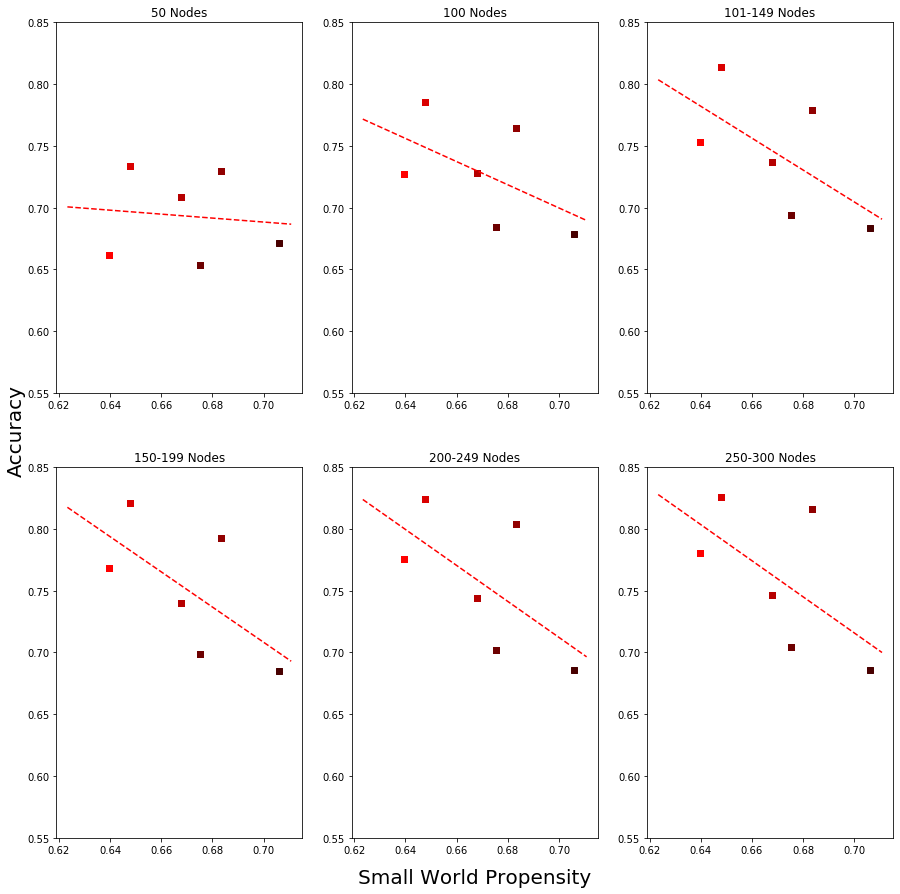

In [332]:
#network junctions switches:
fig1=plt.figure(figsize=(15,15))
ax=[None]*len(nodesList[0])
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_xticks([])
axBig.set_yticks([])
plt.xlabel('Small World Propensity',fontsize=20,labelpad=30)
plt.ylabel('Accuracy',fontsize=20,labelpad=30)
# plt.title('Sorted by Smallworld Propensity',fontsize=30,pad=30)
for i in range(len(ax)): #loop through number of nodes
    count1=0
    count2=0
    count3=0
    X=[]
    Y=[]
    C=[]
    ax[i]=fig1.add_subplot(2, 3, i+1)
    for j in range(len(cluster1)): #loop through networks
        X.append(cluster1sw[count1])
        Y.append(cluster1accuracy[i][count1])#,'-o',label='ASN')
        C.append(hexa[j])
        count1=count1+1
#         if j>=len(cluster1) and j<len(cluster1)+len(cluster2):
#             if count2==0:
#                 plt.scatter(cluster2sw[count2],cluster2accuracy[i][count2],marker='s',color='#ff796c',label='Cluster 2')#,'-o',label='ASN')
#             else:
#                 plt.scatter(cluster2sw[count2],cluster2accuracy[i][count2],marker='s',color='#ff796c')
#             count2=count2+1
#         if j>=len(cluster1)+len(cluster2) and j<len(cluster1)+len(cluster2)+len(cluster3):
#             if count3==0:
#                 plt.scatter(cluster3sw[count3],cluster3accuracy[i][count3],marker='s',color='#8f1402',label='Cluster 3')#,'-o',label='ASN')
#             else:
#                 plt.scatter(cluster3sw[count3],cluster3accuracy[i][count3],marker='s',color='#8f1402')
#             count3=count3+1
#     plt.scatter(smallworld_random,WS_Randomaccuracy[i],label='WS Random',marker='o',color='#06470c')#,'-o',label='WS Random')
#     plt.scatter(smallworld_grid,WS_Gridaccuracy[i],label='WS Grid',marker='o',color='g')#,'-o',label='WS Grid')
#     plt.scatter(Elegans['Graph Theory']['Small World'],Elegans_Accuracy[i],label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
        s.append((ax[i].scatter(X,Y,marker='s',c=C)))#,'-o',label='ASN')
    plt.title(str(labels[i]))
#     plt.legend()
    plt.ylim(0.55,0.85)
    
     # Add correlation line
#         #ASN300
    x=np.array(cluster1sw, dtype=np.float)
    y=np.array(cluster1accuracy[i], dtype=np.float)
    idx = np.isfinite(x) & np.isfinite(y)
    m, b = np.polyfit(x[idx],y[idx], 1)
    X_plot = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '--',color='r')
    
#     x=np.array(cluster2sw, dtype=np.float)
#     y=np.array(cluster2accuracy[i], dtype=np.float)
#     idx = np.isfinite(x) & np.isfinite(y)
#     m, b = np.polyfit(x[idx],y[idx], 1)
#     X_plot = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1],100)
#     plt.plot(X_plot, m*X_plot + b, '--',color='#ff796c')
    
#     x=np.array(cluster3sw, dtype=np.float)
#     y=np.array(cluster3accuracy[i], dtype=np.float)
#     idx = np.isfinite(x) & np.isfinite(y)
#     m, b = np.polyfit(x[idx],y[idx], 1)
#     X_plot = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1],100)
#     plt.plot(X_plot, m*X_plot + b, '--',color='#8f1402')
#      #WS Random
#     x=np.array(smallworld_random, dtype=np.float)
#     y=np.array(WS_Randomaccuracy[i], dtype=np.float)
#     idx = np.isfinite(x) & np.isfinite(y)
#     m, b = np.polyfit(x[idx],y[idx], 1)
#     X_plot = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1],100)
#     plt.plot(X_plot, m*X_plot + b, '-')
    
#     x=np.array(smallworld_grid, dtype=np.float)
#     y=np.array(WS_Gridaccuracy[i], dtype=np.float)
#     idx = np.isfinite(x) & np.isfinite(y)
#     m, b = np.polyfit(x[idx],y[idx], 1)
#     X_plot = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1],100)
#     plt.plot(X_plot, m*X_plot + b, '-')
    
#     plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\Linear Transformation Accuracy vs Small World Prop - Cluster 1.jpg')